Notebook for the <Titanic - Machine Learning from Disaster> Kaggle competitions
Michiel De Vogelaere, May 2025

In this notebook, we will:
1. Import necessary libraries and custom models
2. Data exploration
3. Preprocessing
4. Train and evaluate multiple models
5. Generate evaluation metrics and visualizations
6. Prepare a submission file

# 1. Import necesarry libraries and custom models.

In [1]:
## Import Libraries
import pandas as pd
from sklearn.metrics import *
from matplotlib import pyplot as plt

In [2]:
# Import train and accuracy functions from Model classes
from Models.logistic_regression import LogisticRegressionModel
from Models.decision_tree import DecisionTreeModel 
from Models.random_forest import RandomForestModel
from Models.svm import SVCModel
from Models.gradient_boosting import GradientBoostingClassifierModel
from Models.knn import KNeighborsClassifierModel
from Models.naive_bayes import NaiveBayesModel
from Models.ensemble import EnsembleModel

# 2. Data exploration

1. Loading and Setup
The original training dataset is loaded from a CSV file (train.csv).
A new binary feature HasCabin is created to indicate if a passenger has a cabin assignment (Cabin not null).

2. Basic Data Inspection
The first five rows of the dataset are displayed to preview the data structure.

3. Visualizing Distributions

4. Exploring Relationships with Survival
Sex vs. Survival: A bar plot shows survival rates for male and female passengers.
Pclass vs. Survival: A bar plot shows survival rates by passenger class (1st, 2nd, 3rd).
Embarked vs. Survival: A count plot displays the number of survivors and non-survivors by port of embarkation (C, Q, S).

5. Encoding Categorical Variables
The Embarked column is converted into dummy variables (Embarked_C, Embarked_Q, Embarked_S).

6. Correlation Analysis
A correlation matrix is computed between key features: Survived, Pclass, Age, SibSp, Parch, Fare, HasCabin, and encoded Embarked columns.
The correlation matrix is visualized using a heatmap to highlight relationships.

7. Missing Data Visualization
A heatmap shows the distribution of missing values across all columns, helping to identify where imputation or special handling is needed.

First 5 rows:
    PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  HasCabin  
0      0         A/5 21171   7.2500   NaN        S     False  
1      0          PC 17599  71.2833   C85        C      True  
2      0  STON/O2. 3101282   7.9250   NaN        S     False  
3      0            113803  53.1000  C123        S   

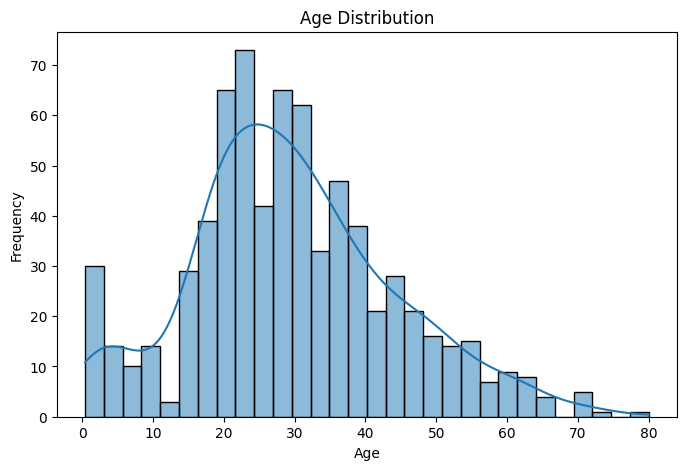

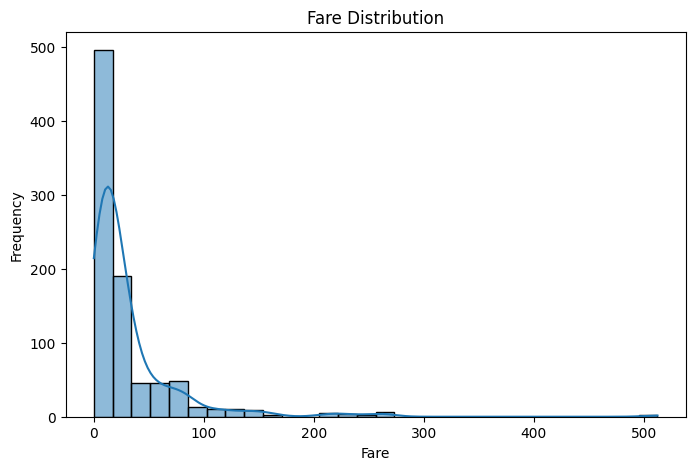

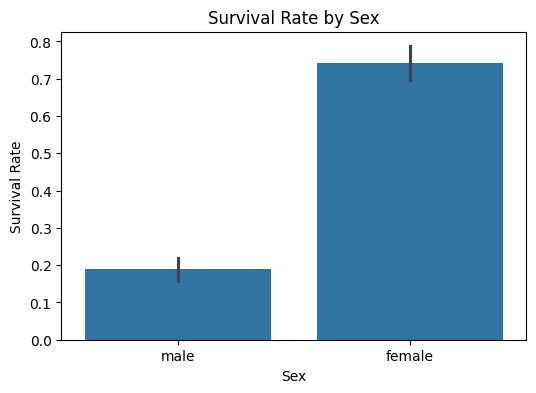

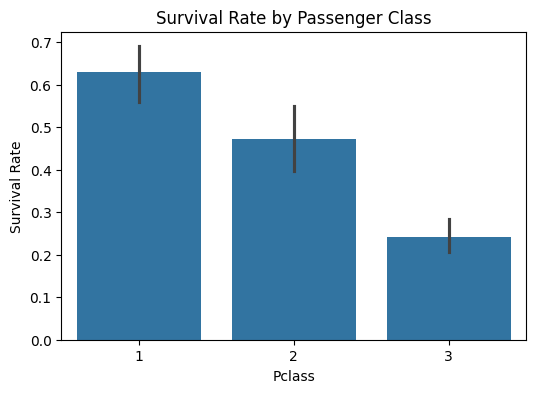

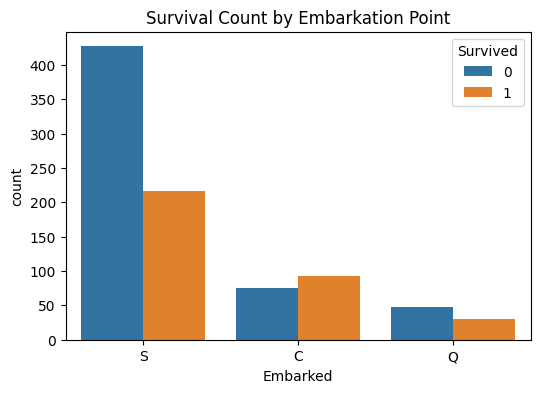

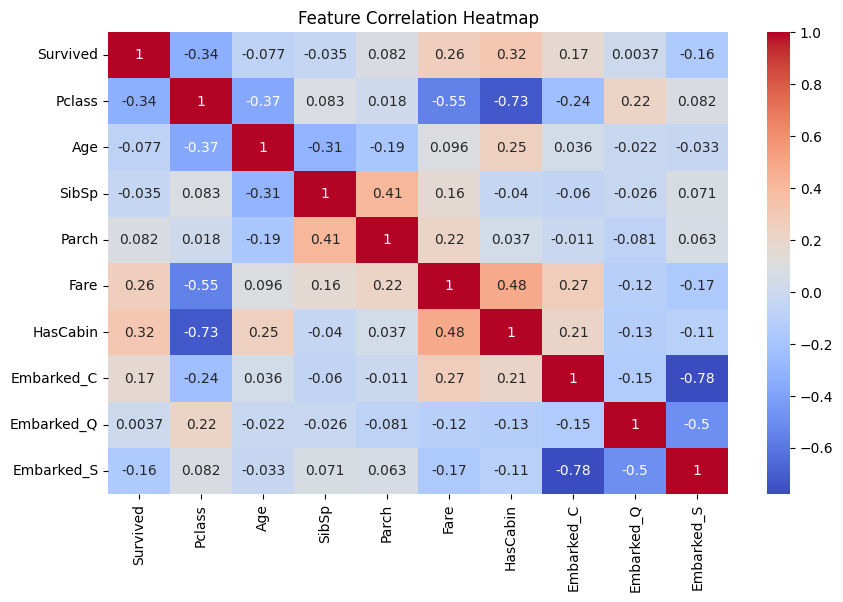

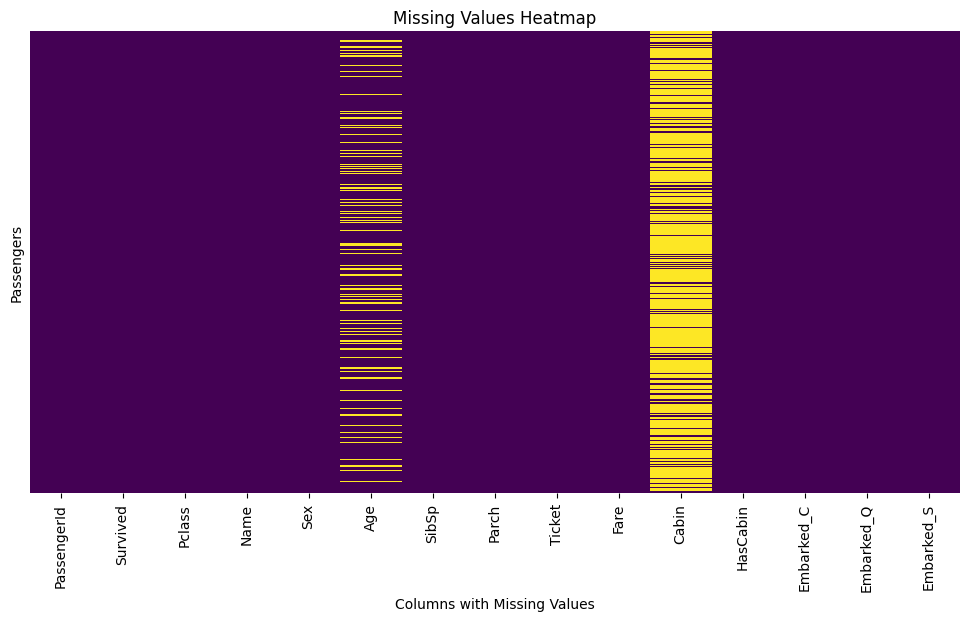

In [3]:
# Run data exploration
%run data_exploration.py

# 3. Preprocessing

1. Loading and Setup
The original training and test datasets are loaded from CSV files.
A folder named Preprocessed_data is created to store processed data.

2. Handling Missing Values
- Age: Missing values in the Age column are replaced by the median age of the training dataset.
- Embarked: Missing values are filled with the most common value (mode), representing the most common port of embarkation.
- Fare: Missing values are replaced by the median fare.
- Cabin: The original Cabin feature contains many missing values. -> feature engineering hasCabin feature.

3. Dropping Unnecessary Columns
The following columns are dropped due to being irrelevant for prediction:
- PassengerId
- Ticket
- Name

4. Feature Engineering
- FamilySize: A new feature representing the total family size is created as SibSp (siblings/spouses) + Parch (parents/children) + 1 (the passenger themself).
- hasCabin: As mentioned, this binary feature captures whether a cabin assignment exists.

5. Encoding Categorical Variables
Sex and Embarked are converted into numerical features using one-hot encoding, dropping the first category to avoid multicollinearity.

6. Splitting the Data
The training data is split into training and validation sets using a random seed for reproducibility.

7. Scaling Numerical Features
Continuous features Age, Pclass, FamilySize, and Fare are standardized to have zero mean and unit variance using StandardScaler. This ensures that features are on the same scale.

8. Saving the Preprocessed Data
All processed datasets (X_train, X_val, X_test, y_train, y_val, and test_passenger_ids) are saved as CSV files in the Preprocessed_data folder.

In [ ]:
# run preprocessing
%run preprocessing.py

# 4. Train and evaluate multiple models

In [ ]:
# Load preprocessed data
X_train = pd.read_csv("Preprocessed_data/X_train_preprocessed.csv")
y_train = pd.read_csv("Preprocessed_data/y_train.csv").squeeze()
X_val   = pd.read_csv("Preprocessed_data/X_val_preprocessed.csv")
y_val   = pd.read_csv("Preprocessed_data/y_val.csv").squeeze()

In [ ]:
# Load models we want to train
models = [
    ("Logistic Regression (submodel)", LogisticRegressionModel()),
    ("Naive Bayes (submodel)", NaiveBayesModel()),
    ("Decision Tree", DecisionTreeModel()),
    ("Random Forest (submodel)", RandomForestModel()),
    ("SVM", SVCModel()),
    ("Gradient Boosting (submodel)", GradientBoostingClassifierModel()),
    ("KNN", KNeighborsClassifierModel()),
    ("Ensemble", EnsembleModel())
]

# 5. Generate evaluation metrics and visualizations

In [ ]:
results = []

for name, model in models:
    print(f"\nTraining {name}...")
    model.train(X_train, y_train)
    
    # Get and print accuracy and AUC
    train_acc, train_auc = model.get_accuracy(X_train, y_train)
    val_acc,   val_auc   = model.get_accuracy(X_val, y_val)
    print(f"{name} - Train Acc: {train_acc:.4f}, AUC: {train_auc:.4f}")
    print(f"{name} - Val   Acc: {val_acc:.4f}, AUC: {val_auc:.4f}")

    # Collect results for grid
    results.append({
        'Model': name,
        'Train Accuracy': train_acc,
        'Train AUC': train_auc,
        'Val Accuracy': val_acc,
        'Val AUC': val_auc
    })

    # Get predictions and probabilities
    y_pred = model.predict(X_val)
    try:
        y_proba = model.predict_proba(X_val)[:, 1]
    except:
        y_proba = None
        print(f"{name} - predict_proba not supported or failed.")
    
    # Print get_basic_metrics
    basic_metrics = model.get_basic_metrics(X_val, y_val)
    print(f"{name} - Basic Metrics:")
    for metric, value in basic_metrics.items():
        print(f"  {metric}: {value:.4f}" if value is not None else f"  {metric}: None")
    
    # Visualize Confusion Matrix
    plt.figure(figsize=(5,4))
    ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    # Visualize ROC Curve 
    if y_proba is not None:
        plt.figure(figsize=(5,4))
        RocCurveDisplay.from_predictions(y_val, y_proba)
        plt.title(f"{name} - ROC Curve")
        plt.show()

# Display the results grid at the end
results_df = pd.DataFrame(results)
print("\nSummary of Model Scores:")
display(results_df)


# 6. Prepare a submission file

In [ ]:
%run submission_csv.py